In [2]:
import setuptools.dist
import tensorflow as tf
from sklearn.metrics import roc_curve, auc
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
import deepdish

#import  torch, torchvision

2024-10-25 01:38:38.974483: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-25 01:38:39.097513: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-25 01:38:39.132324: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-25 01:38:39.330723: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-25 01:38:41.720556: W tensorflow/compiler/tf2

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

data = pd.read_csv('../solutions/galaxyquasar.csv')

u_g = data['u'] - data['g']
g_r = data['g'] - data['r']
r_i = data['r'] - data['i']
i_z = data['i'] - data['z']

labels = data['class'].apply(lambda x: 0 if x == 'GALAXY' else 1)

features = pd.DataFrame({'u-g': u_g, 'g-r': g_r, 'r-i': r_i, 'i-z': i_z})


In [4]:
#let's scale them
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

X_train, X_test, y_train, y_test = train_test_split(features_scaled, labels, test_size=0.3, random_state=42)

### using a neural network classifier let's us avoid the contruction of the neural network, and it's already optimized
 in the other case my computer was struggling in the cross validation

Accuracy: 0.9839333333333333


Text(0.5, 1.0, 'ROC curve')

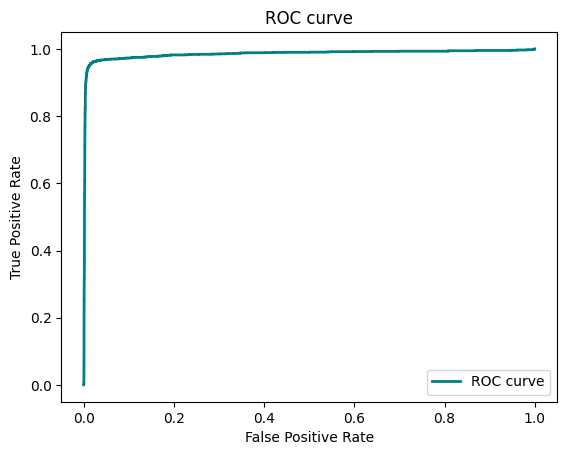

In [6]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# Define the neural network classifier
nn_classifier = MLPClassifier(hidden_layer_sizes=(5,), solver='adam', activation='relu', learning_rate_init=0.001, random_state=42)

nn_classifier.fit(X_train, y_train)

y_pred = nn_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')


# Compute ROC curve
y_score = nn_classifier.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_score)

plt.plot(fpr, tpr, color='teal', lw=2, label='ROC curve')
plt.legend(loc='lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')

/home/malvi/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/tmp/ipykernel_279895/2616256922.py:21: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "o-k" (-> color='k'). The keyword argument will take precedence.
  plt.plot(train_sizes, rms_errors_val, 'o-k', label='Validation Set', color='firebrick')


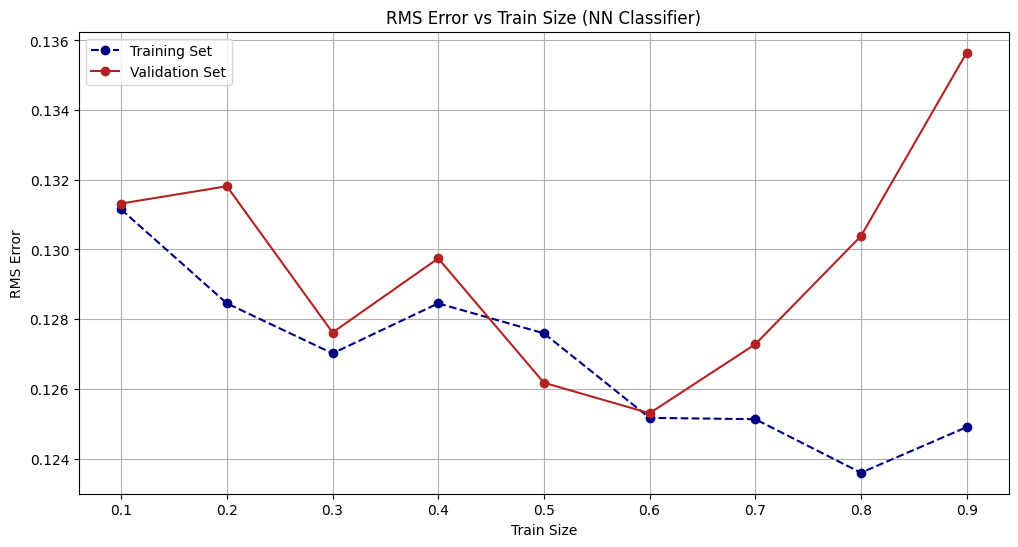

In [8]:
from sklearn.metrics import mean_squared_error

train_sizes = np.linspace(0.1, 0.9, 9)

rms_errors_train = []
rms_errors_val = []

for train_size in train_sizes:
    X_train_var, X_val_var, y_train_var, y_val_var = train_test_split(features_scaled, labels, train_size=train_size, random_state=0)
    
    nn_classifier.fit(X_train_var, y_train_var)
    
    y_train_pred = nn_classifier.predict(X_train_var)
    rms_errors_train.append(np.sqrt(mean_squared_error(y_train_var, y_train_pred)))
    
    y_val_pred = nn_classifier.predict(X_val_var)
    rms_errors_val.append(np.sqrt(mean_squared_error(y_val_var, y_val_pred)))

plt.figure(figsize=(12, 6))
plt.plot(train_sizes, rms_errors_train, 'o--', label='Training Set', color='navy')
plt.plot(train_sizes, rms_errors_val, 'o-k', label='Validation Set', color='firebrick')
plt.xlabel('Train Size')
plt.ylabel('RMS Error')
plt.title('RMS Error vs Train Size (NN Classifier)')
plt.legend()
plt.grid(True)
plt.show()


In [22]:
from sklearn.model_selection import GridSearchCV
import warnings

param_grid = {
    'hidden_layer_sizes': [(5,), (10,), (5, 5), (10, 10)],
    'learning_rate_init': [0.001, 0.01, 0.1],
    'activation': ['relu', 'tanh', 'sigmoid']  }

mlp = MLPClassifier(solver='adam', random_state=42)

grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f'Best Parameters: {best_params}')
print(f'Best Cross-Validation Accuracy: {best_score}')

warnings.filterwarnings('ignore')

/home/malvi/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
60 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
32 fits failed with the following error:
Traceback (most recent call last):
  File "/home/malvi/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/malvi/venv/lib/python3.12/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/home/malvi/venv/lib/python3.12/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/home/malvi/venv/lib/python3.1

Best Parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10,), 'learning_rate_init': 0.01}
Best Cross-Validation Accuracy: 0.9854857142857144


In [26]:
print(f'Best Parameters: {best_params}')
print(f'Best Cross-Validation Accuracy: {best_score}')

Best Parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10,), 'learning_rate_init': 0.01}
Best Cross-Validation Accuracy: 0.9854857142857144


In [23]:
neurons = best_params['hidden_layer_sizes']
learning_rate = best_params['learning_rate_init']
activation_ = best_params['activation']

final_nn_classifier = MLPClassifier(hidden_layer_sizes=neurons, solver='adam', activation=activation_, learning_rate_init=learning_rate, random_state=42)

final_nn_classifier.fit(X_train, y_train)

train_accuracy = final_nn_classifier.score(X_train, y_train)
test_accuracy = final_nn_classifier.score(X_test, y_test)

print(f"Final Model - Train Accuracy: {train_accuracy:.4f}")
print(f"Final Model - Test Accuracy: {test_accuracy:.4f}")


Final Model - Train Accuracy: 0.9857
Final Model - Test Accuracy: 0.9857


In [27]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42, n_estimators=100)

# Train the model
rf.fit(X_train, y_train)

# Evaluate the model
rf_train_accuracy = rf.score(X_train, y_train)
rf_test_accuracy = rf.score(X_test, y_test)

print(f"Random Forest Train Accuracy: {rf_train_accuracy:.4f}")
print(f"Random Forest Test Accuracy: {rf_test_accuracy:.4f}")


Random Forest Train Accuracy: 1.0000
Random Forest Test Accuracy: 0.9868


I could find that one can evaluate the importce of features by randomly shuffling them and see how the performance is worsened

In [25]:
from sklearn.inspection import permutation_importance
#
result = permutation_importance(final_nn_classifier, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
feature_importances = result.importances_mean

for feature, importance in zip(features.columns, feature_importances):
    print(f'{feature}: {importance}')

u-g: 0.2381333333333334
g-r: 0.003553333333333364
r-i: 0.0033733333333333614
i-z: 0.011766666666666693
